# Importing Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from torch.autograd import Variable

# Reading and Transforming Data

In [2]:
cols=['category','message']
data= pd.read_csv("/content/SMSSpamCollection.tsv", delimiter='\t', names=cols)
data.head()

,category,message
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


Let's do some transformations!

In [3]:
data['category']=data['category'].map({'ham':0,'spam':1})
data.head()

,category,message
0,0,I've been searching for the right words to tha...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,"Nah I don't think he goes to usf, he lives aro..."
3,0,Even my brother is not like to speak with me. ...
4,0,I HAVE A DATE ON SUNDAY WITH WILL!!


In [4]:
# Making arrays for labels and features

features=data.message.values
labels=data.category.values
print(features.shape)
print(labels.shape)

(5568,)
(5568,)


In [5]:
t = Tokenizer(num_words=1000)
t.fit_on_texts(features)
features = t.texts_to_matrix(features, mode='tfidf')

In [6]:
features.shape

(5568, 1000)

# Building Model

In [7]:
class Model(nn.Module):
  def __init__(self,input,hidden,output):
    super(Model,self).__init__()
    self.l1=nn.Linear(input,hidden)
    self.l2=nn.Linear(hidden,hidden)
    self.l3=nn.Linear(hidden,output)

  def forward(self,x):
    out= F.relu(self.l1(x))
    out=F.relu(self.l2(out))
    out=self.l3(out)
    return out


In [8]:
input=1000
hidden=100
output=2
model=Model(input,hidden,output)

In [9]:
# Calculaitng Params 
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #(1000*100+100)+(100*100+10)+(100*2+2)=110,402
print(pytorch_total_params)

110402


In [10]:
# Let's do train/test split
X_train,X_test, y_train,y_test=train_test_split(features,labels,shuffle=True,random_state=3)

In [11]:
# Let's define our loss function and optimization technique
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Model
Using:
1. Using batch gradient descent
2. Corssentropy loss function
3. Adam optimizer

In [12]:
# let's use batch gradient descent for training our baby that we created above! (if epochs=10 then 10 exposures to entire training data for learning)
def train(epochs):
    x_train = Variable(torch.from_numpy(X_train)).float()
    y_train_ = Variable(torch.from_numpy(y_train)).long()
    model.train()
    train_losses=[]
    for epoch in range(epochs):
        optimizer.zero_grad() # still fuzzy not clear!
        y_pred = model(x_train)
        loss_ = loss(y_pred, y_train_)
        train_losses.append(loss_.item())
        print ("epoch #",epoch)
        print ("loss: ", loss_.item())
        pred = torch.max(y_pred, 1)[1].eq(y_train_).sum()######smokeeeeeeeeeeeeeeeeeees!(Expanded below)
        print ("acc:(%) ", (100*pred/len(x_train)))
        loss_.backward()
        optimizer.step()
    return (y_pred, train_losses)

Let's expand `torch.max(y_pred, 1)[1].eq(y_train_).sum()` for comprehension

In [13]:
a=train(1)[0]
a # a is equivalent to y_pred from above

epoch # 0
loss:  0.701265275478363
acc:(%)  tensor(31.5613)


tensor([[-0.0631, -0.0545],
        [-0.0365, -0.0730],
        [-0.0350, -0.0411],
        ...,
        [-0.0731, -0.0206],
        [-0.0560, -0.1088],
        [-0.0598, -0.0265]], grad_fn=<AddmmBackward0>)

In [14]:
torch.max(a) # collects max value of entire matrix

tensor(0.1880, grad_fn=<MaxBackward1>)

In [15]:
torch.max(a,1) # collections max value row-wise

torch.return_types.max(values=tensor([-0.0545, -0.0365, -0.0350,  ..., -0.0206, -0.0560, -0.0265],
       grad_fn=<MaxBackward0>), indices=tensor([1, 0, 0,  ..., 1, 0, 1]))

In [16]:
torch.max(a,1)[1]

tensor([1, 0, 0,  ..., 1, 0, 1])

In [17]:
y_train_ = Variable(torch.from_numpy(y_train)).long()
torch.max(a,1)[1].eq(y_train_)


tensor([False, False,  True,  ..., False,  True, False])

In [18]:
torch.max(a,1)[1].eq(y_train_).sum() # total number of correct predictions on training set

tensor(1318)

In [19]:
train(10)

epoch # 0
loss:  0.41323670744895935
acc:(%)  tensor(86.9013)
epoch # 1
loss:  0.2527587413787842
acc:(%)  tensor(86.9013)
epoch # 2
loss:  0.18717679381370544
acc:(%)  tensor(86.9013)
epoch # 3
loss:  0.14776746928691864
acc:(%)  tensor(89.5354)
epoch # 4
loss:  0.12029463797807693
acc:(%)  tensor(95.1149)
epoch # 5
loss:  0.0981266126036644
acc:(%)  tensor(97.9885)
epoch # 6
loss:  0.07764652371406555
acc:(%)  tensor(98.8027)
epoch # 7
loss:  0.05832155421376228
acc:(%)  tensor(99.2337)
epoch # 8
loss:  0.0415818952023983
acc:(%)  tensor(99.3774)
epoch # 9
loss:  0.02961404249072075
acc:(%)  tensor(99.3774)


(tensor([[ 16.9195, -16.7566],
         [ -0.9924,   1.4697],
         [  1.5620,  -1.5644],
         ...,
         [  1.6617,  -1.7136],
         [ 17.9558, -18.0262],
         [  7.4841,  -7.5203]], grad_fn=<AddmmBackward0>),
 [0.41323670744895935,
  0.2527587413787842,
  0.18717679381370544,
  0.14776746928691864,
  0.12029463797807693,
  0.0981266126036644,
  0.07764652371406555,
  0.05832155421376228,
  0.0415818952023983,
  0.02961404249072075])

# Testing Model 

In [20]:
def test(epochs):
    model.eval()
    x_test = Variable(torch.from_numpy(X_test)).float()
    y_test_ = Variable(torch.from_numpy(y_test)).long()
    test_loss=[]
    for epoch in range(epochs):
        with torch.no_grad():
            y_pred = model(x_test)
            loss_ = loss(y_pred, y_test_)
            test_loss.append(loss_.item())
            print ("epoch #",epoch)
            print ("loss: ", loss_.item())
            pred = torch.max(y_pred, 1)[1].eq(y_test_).sum()
            print ("acc (%): ", 100*pred/len(x_test))


In [21]:
test(1)

epoch # 0
loss:  0.09993883967399597
acc (%):  tensor(98.3477)


In [22]:
train_loss= train(200)[1]

epoch # 0
loss:  0.022390849888324738
acc:(%)  tensor(99.3774)
epoch # 1
loss:  0.01809711568057537
acc:(%)  tensor(99.4013)
epoch # 2
loss:  0.015372006222605705
acc:(%)  tensor(99.4013)
epoch # 3
loss:  0.013401861302554607
acc:(%)  tensor(99.4492)
epoch # 4
loss:  0.011590590700507164
acc:(%)  tensor(99.5450)
epoch # 5
loss:  0.009620520286262035
acc:(%)  tensor(99.6169)
epoch # 6
loss:  0.007649022154510021
acc:(%)  tensor(99.6887)
epoch # 7
loss:  0.005856744479387999
acc:(%)  tensor(99.7605)
epoch # 8
loss:  0.0046293470077216625
acc:(%)  tensor(99.8084)
epoch # 9
loss:  0.003869052976369858
acc:(%)  tensor(99.8563)
epoch # 10
loss:  0.003310458268970251
acc:(%)  tensor(99.9282)
epoch # 11
loss:  0.002894491655752063
acc:(%)  tensor(99.9282)
epoch # 12
loss:  0.002541300840675831
acc:(%)  tensor(99.9521)
epoch # 13
loss:  0.002257880289107561
acc:(%)  tensor(99.9761)
epoch # 14
loss:  0.0020452330354601145
acc:(%)  tensor(99.9761)
epoch # 15
loss:  0.0018995247082784772
acc:(%)  

# Plotting Training Loss

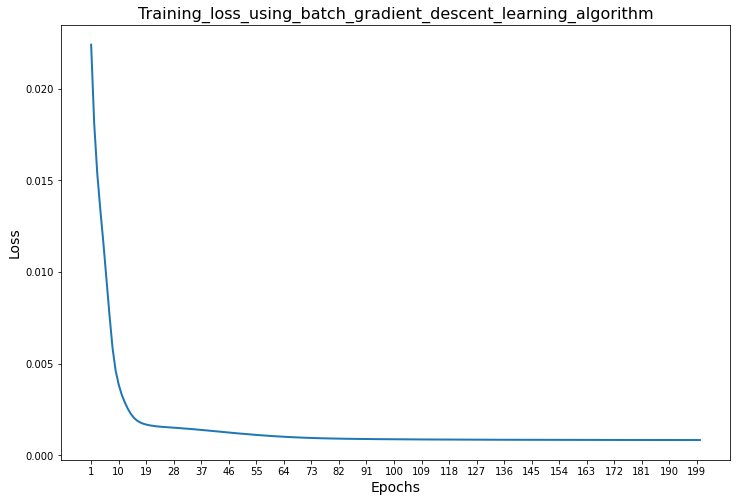

In [30]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(1,201,1)],train_loss,lw=2)
plt.xlabel('Epochs',size=14)
plt.ylabel('Loss',size=14)
plt.xticks([i for i in range(1,201,9)],labels=[i for i in range(1,201,9)])
plt.title("Training_loss_using_batch_gradient_descent_learning_algorithm",size=16)
plt.show()